<a href="https://colab.research.google.com/github/ThalyaGIT/UK-Music-Index-Returns/blob/main/3_data-analysis_notebooks/proposal%2B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction and Background**
**Objective:** Explore the relationship between Changes in Spotify UK Top 200 songs SWAV (Streamed Weighted Average Valence), a sentiment measure derived from music streaming data, and the returns of major UK market indices (FTSE 100, FTSE 250, and FTSE Small Cap).

**Context:** Based on Edmans' global study, which identified a positive relationship between sentiment and global index returns.

**Focus:** Determine whether similar sentiment-market return patterns exist within the UK, with a particular emphasis on how sentiment influences market behavior.

In [155]:
# @title
# Import packages
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats.mstats import winsorize
from scipy.stats import zscore

# Open CSVs into dataframe
url_1_day = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_1_days.csv'
url_3_day = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_3_days.csv'
url_5_day = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_5_days.csv'
url_10_day = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_10_days.csv'
url_20_day = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_20_days.csv'

df_1_day = pd.read_csv(url_1_day)
df_3_day = pd.read_csv(url_3_day)
df_5_day = pd.read_csv(url_5_day)
df_10_day = pd.read_csv(url_10_day)
df_20_day = pd.read_csv(url_20_day)


# Open CSV into dataframe with TED
url_1_day_TED = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_1_days_TED.csv'
url_3_day_TED = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_3_days_TED.csv'
url_5_day_TED = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_5_days_TED.csv'
url_10_day_TED = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_10_days_TED.csv'
url_20_day_TED = 'https://raw.githubusercontent.com/ThalyaGIT/UK-Music-Index-Returns/main/0-data-gold/data_20_days_TED.csv'

df_1_day_TED = pd.read_csv(url_1_day_TED)
df_3_day_TED = pd.read_csv(url_3_day_TED)
df_5_day_TED = pd.read_csv(url_5_day_TED)
df_10_day_TED = pd.read_csv(url_10_day_TED)
df_20_day_TED = pd.read_csv(url_20_day_TED)

# **Initial Analysis: SWAV and FTSE Indices**

The initial regression analysis shows a significant ***negative relationship*** between changes in SWAV and FTSE 100 returns, which contrasts with the global positive relationship found by Edmans.

This could indicate that the FTSE 100 is perceived differently within the UK context. The global ownership of FTSE 100 holdings may introduce additional noise into the relationship, potentially influencing the results. These findings suggest a need for further investigation to understand the underlying dynamics.

In [156]:
# @title
# Initialize an empty list to store results
results = []
model_summaries = []  # Store model summaries to print later

indices = ['FTSE100', 'FTSE250', 'FTSESmallCap']
days_list = [5]

for days in days_list:
    result_row = [days]  # Start the row with the number of days
    for index in indices:
        df = globals()[f'df_{days}_day']  # Dynamically access each DataFrame

        # Ensure 'Date' column is in datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract the month from the 'Date' column
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day

        # Define the dependent variable
        y = df[f'% {index} Change']

        # Define the independent variables
        X = df[['Change in SWAV',
                'ADS_Change',
                'EPU_Change',
                f'Previous % {index} Change',
                '% MSCI Change',
                'Vix Close',
                'Rolling_Avg_Change_in_DCC']]

        # Convert all columns to numeric, coercing errors to NaN
        X = X.apply(pd.to_numeric, errors='coerce')
        y = pd.to_numeric(y, errors='coerce')

        # Drop rows with any NaN values
        X = X.dropna()
        y = y.loc[X.index]  # Ensure 'y' aligns with 'X' after dropping NaNs

        # Ensure that both X and y are aligned and are purely numeric
        if X.shape[0] > 0 and y.shape[0] > 0:  # Proceed only if there's valid data
            # Add a constant term to the model
            X = sm.add_constant(X)

            # Fit the model
            model = sm.OLS(y, X).fit()

            # Extract the coefficient and p-value for 'Change in SWAV'
            coef = round(model.params['Change in SWAV'], 2)
            p_value = round(model.pvalues['Change in SWAV'], 5)

            # Store the coefficient and p-value as a tuple
            result_row.append((coef, p_value))

            # Store the model summary to print later if significant
            if p_value < 0.1:
                model_summaries.append((index, days, model.summary()))

        else:
            result_row.append((None, None))  # Store None for both if no valid data

    # Append the result row for this combination of days
    results.append(result_row)

# Define column names dynamically, ensuring "Days" is the first column
columns = ['Business Days']
for index in indices:
    columns.extend([f'SWAV Change on {index} Change'])

# Convert the results list to a DataFrame, extracting only the coefficients
results_df = pd.DataFrame([[row[0]] + [r[0] if isinstance(r, tuple) else None for r in row[1:]] for row in results], columns=columns)

# Define a function to apply the styling based on significance
def color_rows(row, original_results):
    colors = []
    for i in range(1, len(row)):  # Skip Days, then iterate through Coefs
        # Safely access the original tuple
        item = original_results[row.name][i]
        if isinstance(item, tuple):
            coef, p_value = item
            if coef is not None and p_value < 0.1:  # Only color if p-value < 0.1 (significant)
                if coef > 0:
                    colors.append('background-color: lightgreen')
                elif coef < 0:
                    colors.append('background-color: lightpink')
                else:
                    colors.append('')
            else:
                colors.append('')  # No color for non-significant or None
        else:
            colors.append('')  # No color if item is not a tuple
    return [''] * 1 + colors  # No coloring for Days

# Apply the function to each row of the DataFrame, passing the original results
styled_df = results_df.style.apply(color_rows, axis=1, original_results=results)

# Display the styled DataFrame (in Jupyter or similar environments)
box_message = (
    "--------------------------------------------\n"
    "| Coefficients of 'Change in SWAV' by index |\n"
    "|                                           |\n"
    "| Light green: Significant positive (10%)   |\n"
    "| Light pink: Significant negative (10%)    |\n"
    "--------------------------------------------\n"
)

print(box_message)
display(styled_df)

# Print all the stored model summaries after displaying the styled DataFrame
for index, days, summary in model_summaries:
    print(f"\n\033[1mModel Summary for {index} at {days} days:\033[0m")
    print(summary)

--------------------------------------------
| Coefficients of 'Change in SWAV' by index |
|                                           |
| Light green: Significant positive (10%)   |
| Light pink: Significant negative (10%)    |
--------------------------------------------



,Business Days,SWAV Change on FTSE100 Change,SWAV Change on FTSE250 Change,SWAV Change on FTSESmallCap Change
0,5,-5.360000,-1.300000,2.090000



Model Summary for FTSE100 at 5 days:
                            OLS Regression Results                            
Dep. Variable:       % FTSE100 Change   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     340.4
Date:                Sat, 31 Aug 2024   Prob (F-statistic):          3.50e-318
Time:                        17:46:39   Log-Likelihood:                -3032.3
No. Observations:                1712   AIC:                             6081.
Df Residuals:                    1704   BIC:                             6124.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

# **Exploratory Analysis: Seasonal Extremes in SWAV**
During exploratory analysis, I found extreme changes in SWAV in December and January, likely due to Christmas music. I will show the distribution of SWAV and its changes across months to illustrate this festive impact on sentiment data.

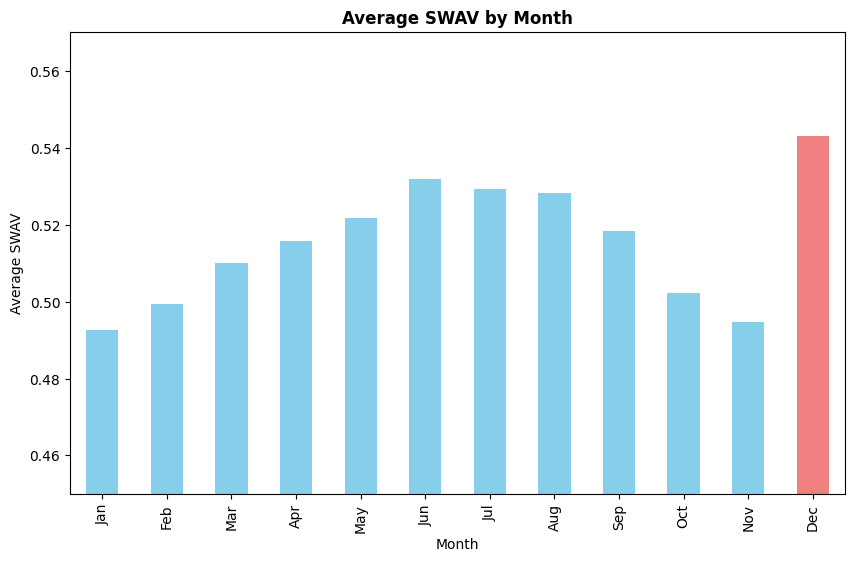

In [157]:
# @title
# Ensure 'Date' column is in datetime format
df_5_day['Date'] = pd.to_datetime(df_5_day['Date'])

# Extract the month from the 'Date' column
df_5_day['Month'] = df_5_day['Date'].dt.month

# Calculate the average 'SWAV' by month
monthly_avg = df_5_day.groupby('Month')['SWAV'].mean()

# Plot the average 'SWAV' by month
plt.figure(figsize=(10, 6))

# Assign colors, with December as a pinkish color
colors = ['skyblue'] * 11 + ['lightcoral']  # 'lightcoral' is a pinkish color

monthly_avg.plot(kind='bar', color=colors)
plt.title('Average SWAV by Month', fontsize=12, fontweight='bold', ha='center')
plt.xlabel('Month')
plt.ylabel('Average SWAV')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylim(0.45)  # Set the y-axis to start at 0.45
plt.show()

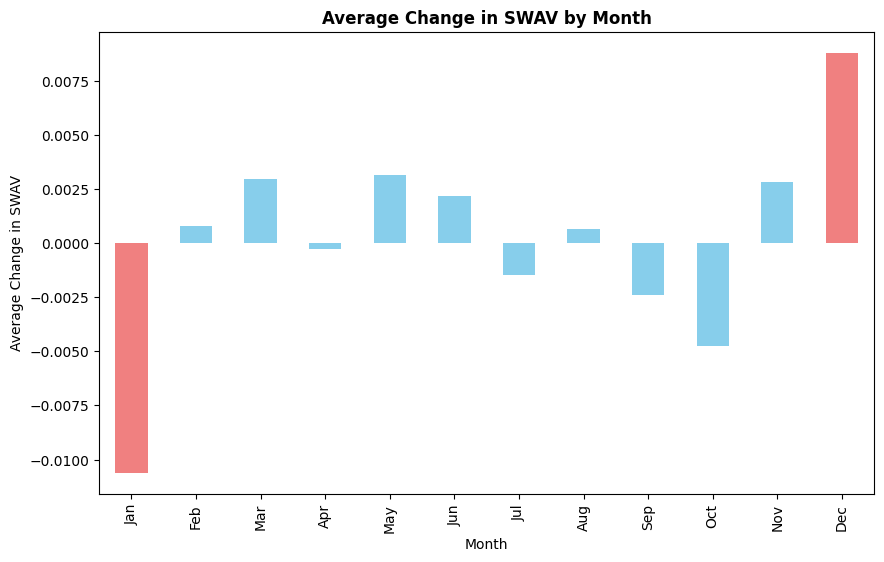

In [158]:
# @title
# Calculate the average 'Change in SWAV' by month
monthly_avg = df_5_day.groupby('Month')['Change in SWAV'].mean()

# Plot the average 'Change in SWAV' by month
plt.figure(figsize=(10, 6))

# Assign colors, with January and December as light coral
colors = ['lightcoral'] + ['skyblue'] * 10 + ['lightcoral']

monthly_avg.plot(kind='bar', color=colors)
plt.title('Average Change in SWAV by Month', fontsize=12, fontweight='bold', ha='center')
plt.xlabel('Month')
plt.ylabel('Average Change in SWAV')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

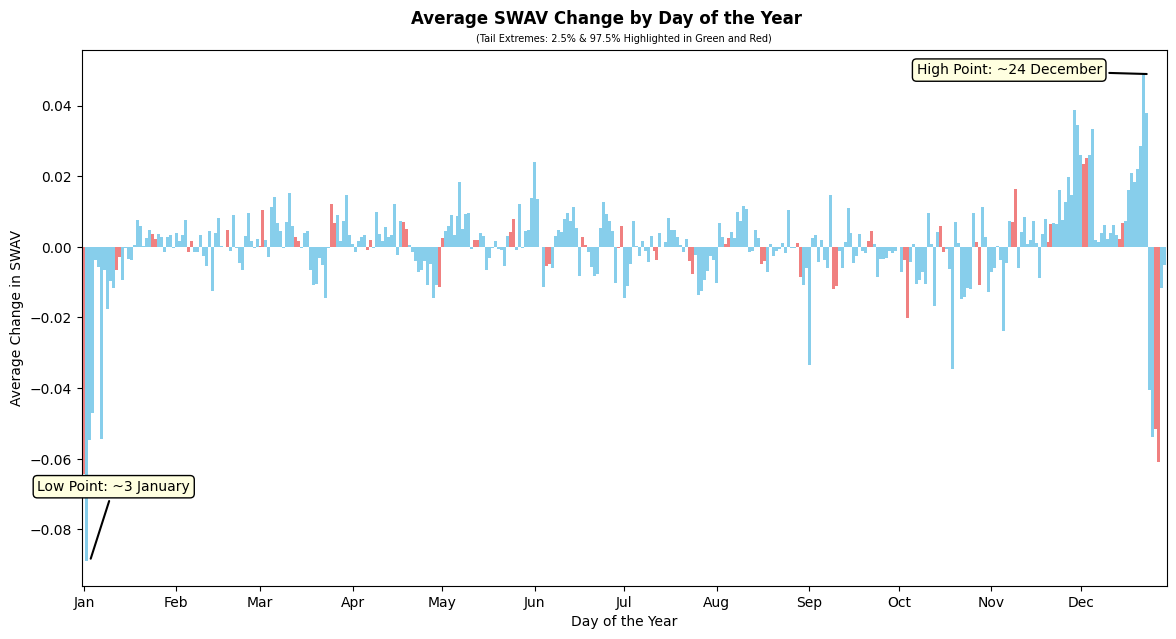

In [159]:
# @title
# Assuming df_5_day is your DataFrame with 'Date' and 'Change in SWAV' columns
df = df_5_day.copy()

# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract day of the year (1-365 or 1-366 for leap years)
df['DayOfYear'] = df['Date'].dt.dayofyear

# Calculate the average 'Change in SWAV' by each day of the year
daily_avg = df.groupby('DayOfYear')['Change in SWAV'].mean()

# # Define customized thresholds for increases and decreases
# increase_threshold = 0.02  # Less extreme for increases
# decrease_threshold = -0.05  # More extreme for decreases

# Plot the average 'Change in SWAV' by day of the year
plt.figure(figsize=(14, 8))

ax = daily_avg.plot(kind='bar', color=colors, width=1.0)

# Adjust the space above the plot to make room for the titles
plt.subplots_adjust(top=0.78)

# Adding the main title at the top
plt.suptitle('Average SWAV Change by Day of the Year', fontsize=12, fontweight='bold', y=0.83, ha='center')

# Adding the subtitle just below the main title
plt.title('(Tail Extremes: 2.5% & 97.5% Highlighted in Green and Red)', fontsize=7, y=1, ha='center')

plt.xlabel('Day of the Year')
plt.ylabel('Average Change in SWAV')
plt.xticks(ticks=[0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334], labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)

# Example Annotations
plt.annotate('High Point: ~24 December', xy=(357, daily_avg[358]),
             xytext=(310, daily_avg[358]),
             arrowprops=dict(facecolor='black', arrowstyle="-", lw=1.5),
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightyellow'),
             fontsize=10, ha='center')

plt.annotate('Low Point: ~3 January', xy=(2, daily_avg[3]),
             xytext=(10, daily_avg[3] + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle="-", lw=1.5),
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightyellow'),
             fontsize=10, ha='center')

plt.show()

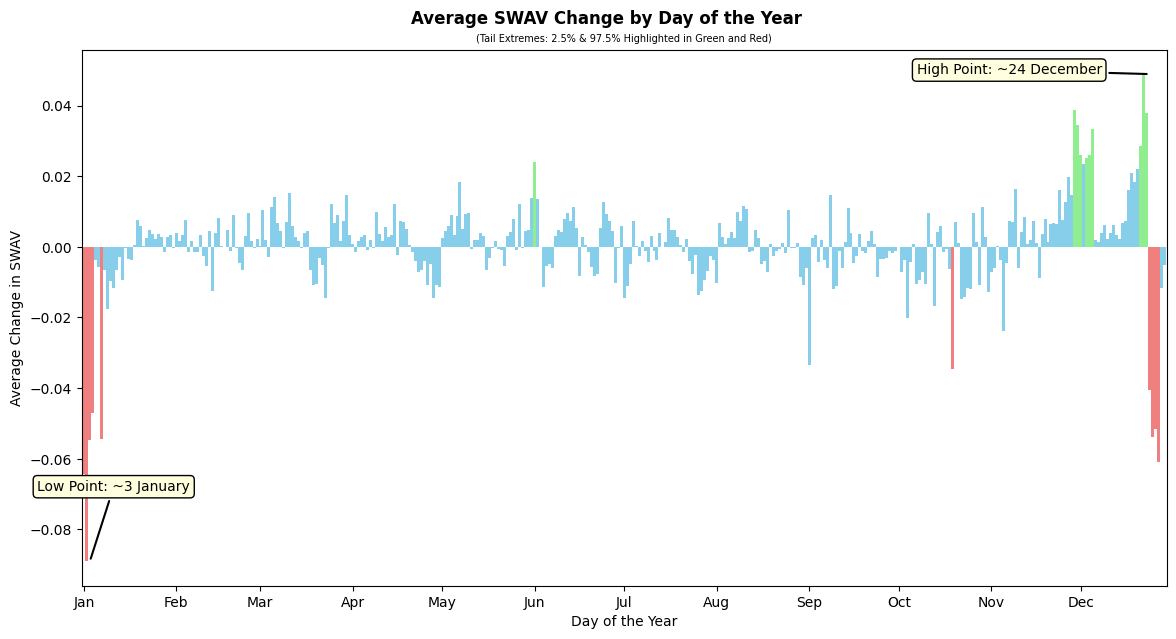

In [160]:
# @title
# Assuming df_5_day is your DataFrame with 'Date' and 'Change in SWAV' columns
df = df_5_day.copy()

# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract day of the year (1-365 or 1-366 for leap years)
df['DayOfYear'] = df['Date'].dt.dayofyear

# Calculate the average 'Change in SWAV' by each day of the year
daily_avg = df.groupby('DayOfYear')['Change in SWAV'].mean()

# # Define customized thresholds for increases and decreases
# increase_threshold = 0.02  # Less extreme for increases
# decrease_threshold = -0.05  # More extreme for decreases

# Calculate the 1st and 99th percentiles for the daily averages
percentile_1 = daily_avg.quantile(0.025)
percentile_99 = daily_avg.quantile(0.975)

# Identify extremes (below the 1st percentile or above the 99th percentile)
extremes = daily_avg[(daily_avg < percentile_1) | (daily_avg > percentile_99)]

# Plot the average 'Change in SWAV' by day of the year
plt.figure(figsize=(14, 8))

# Highlight positive extremes with lightgreen, negative extremes with lightcoral, otherwise skyblue
colors = ['lightgreen' if day in extremes.index and daily_avg[day] > 0 else
          'lightcoral' if day in extremes.index and daily_avg[day] < 0 else
          'skyblue' for day in daily_avg.index]

ax = daily_avg.plot(kind='bar', color=colors, width=1.0)


# Adjust the space above the plot to make room for the titles
plt.subplots_adjust(top=0.78)

# Adding the main title at the top
plt.suptitle('Average SWAV Change by Day of the Year', fontsize=12, fontweight='bold', y=0.83, ha='center')

# Adding the subtitle just below the main title
plt.title('(Tail Extremes: 2.5% & 97.5% Highlighted in Green and Red)', fontsize=7, y=1, ha='center')

plt.xlabel('Day of the Year')
plt.ylabel('Average Change in SWAV')
plt.xticks(ticks=[0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334], labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)

# Example Annotations
plt.annotate('High Point: ~24 December', xy=(357, daily_avg[358]),
             xytext=(310, daily_avg[358]),
             arrowprops=dict(facecolor='black', arrowstyle="-", lw=1.5),
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightyellow'),
             fontsize=10, ha='center')

plt.annotate('Low Point: ~3 January', xy=(2, daily_avg[3]),
             xytext=(10, daily_avg[3] + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle="-", lw=1.5),
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightyellow'),
             fontsize=10, ha='center')

plt.show()

# **Festivity Adjustment: Control for festivity**

Given the extreme positive SWAV changes during December (due to festive music) and the sharp drop in January, these months were excluded from the dataset.

This adjustment suggests that the extreme seasonal effects in December and January influenced the observed relationships:

*   The ***negative relationship*** between SWAV changes and FTSE 100 returns remains significant, indicating a consistent pattern outside of these months.

*   The ***positive relationship*** with FTSE Small Cap returns becomes evident, highlighting a potential link between sentiment and smaller, riskier stocks.


In [161]:
# @title
# Initialize an empty list to store results
results = []
model_summaries = []  # Store model summaries to print later

indices = ['FTSE100', 'FTSE250', 'FTSESmallCap']
days_list = [5]

for days in days_list:
    result_row = [days]  # Start the row with the number of days
    for index in indices:
        df = globals()[f'df_{days}_day']  # Dynamically access each DataFrame

        # Ensure 'Date' column is in datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract the month and day from the 'Date' column
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day

        # Create a festive season dummy variable for December 25th to January 5th
        df['Festive_Season'] = (
            ((df['Month'] == 12) & (df['Day'] >= 24)) |
            ((df['Month'] == 1) & (df['Day'] <= 3))
        ).astype(int)

        # Define the dependent variable
        y = df[f'% {index} Change']

        # Define the independent variables, including Festive_Season
        X = df[['Change in SWAV',
                'ADS_Change',
                'EPU_Change',
                f'Previous % {index} Change',
                '% MSCI Change',
                'Vix Close',
                'Rolling_Avg_Change_in_DCC',
                'Festive_Season']]  # Add Festive_Season here

        # Convert all columns to numeric, coercing errors to NaN
        X = X.apply(pd.to_numeric, errors='coerce')
        y = pd.to_numeric(y, errors='coerce')

        # Drop rows with any NaN values
        X = X.dropna()
        y = y.loc[X.index]  # Ensure 'y' aligns with 'X' after dropping NaNs

        # Ensure that both X and y are aligned and are purely numeric
        if X.shape[0] > 0 and y.shape[0] > 0:  # Proceed only if there's valid data
            # Add a constant term to the model
            X = sm.add_constant(X)

            # Fit the model
            model = sm.OLS(y, X).fit()

            # Extract the coefficient and p-value for 'Change in SWAV'
            coef = round(model.params['Change in SWAV'], 2)
            p_value = round(model.pvalues['Change in SWAV'], 5)

            # Store the coefficient and p-value as a tuple
            result_row.append((coef, p_value))

            # Store the model summary to print later if significant
            if p_value < 0.1:
                model_summaries.append((index, days, model.summary()))

        else:
            result_row.append((None, None))  # Store None for both if no valid data

    # Append the result row for this combination of days
    results.append(result_row)

# Define column names dynamically, ensuring "Days" is the first column
columns = ['Business Days']
for index in indices:
    columns.extend([f'SWAV Change on {index} Change'])

# Convert the results list to a DataFrame, extracting only the coefficients
results_df = pd.DataFrame([[row[0]] + [r[0] if isinstance(r, tuple) else None for r in row[1:]] for row in results], columns=columns)

# Define a function to apply the styling based on significance
def color_rows(row, original_results):
    colors = []
    for i in range(1, len(row)):  # Skip Days, then iterate through Coefs
        # Safely access the original tuple
        item = original_results[row.name][i]
        if isinstance(item, tuple):
            coef, p_value = item
            if coef is not None and p_value < 0.1:  # Only color if p-value < 0.1 (significant)
                if coef > 0:
                    colors.append('background-color: lightgreen')
                elif coef < 0:
                    colors.append('background-color: lightpink')
                else:
                    colors.append('')
            else:
                colors.append('')  # No color for non-significant or None
        else:
            colors.append('')  # No color if item is not a tuple
    return [''] * 1 + colors  # No coloring for Days

# Apply the function to each row of the DataFrame, passing the original results
styled_df = results_df.style.apply(color_rows, axis=1, original_results=results)

# Display the styled DataFrame (in Jupyter or similar environments)
box_message = (
    "--------------------------------------------\n"
    "| Coefficients of 'Change in SWAV' by index |\n"
    "|                                           |\n"
    "| Light green: Significant positive (10%)   |\n"
    "| Light pink: Significant negative (10%)    |\n"
    "--------------------------------------------\n"
)

print(box_message)
display(styled_df)

# Print all the stored model summaries after displaying the styled DataFrame
for index, days, summary in model_summaries:
    print(f"\n\033[1mModel Summary for {index} at {days} days:\033[0m")
    print(summary)

--------------------------------------------
| Coefficients of 'Change in SWAV' by index |
|                                           |
| Light green: Significant positive (10%)   |
| Light pink: Significant negative (10%)    |
--------------------------------------------



,Business Days,SWAV Change on FTSE100 Change,SWAV Change on FTSE250 Change,SWAV Change on FTSESmallCap Change
0,5,-5.060000,1.040000,4.600000



Model Summary for FTSE100 at 5 days:
                            OLS Regression Results                            
Dep. Variable:       % FTSE100 Change   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     297.7
Date:                Sat, 31 Aug 2024   Prob (F-statistic):          5.84e-317
Time:                        17:46:43   Log-Likelihood:                -3032.1
No. Observations:                1712   AIC:                             6082.
Df Residuals:                    1703   BIC:                             6131.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

# **Create Residual Change in SWAV**

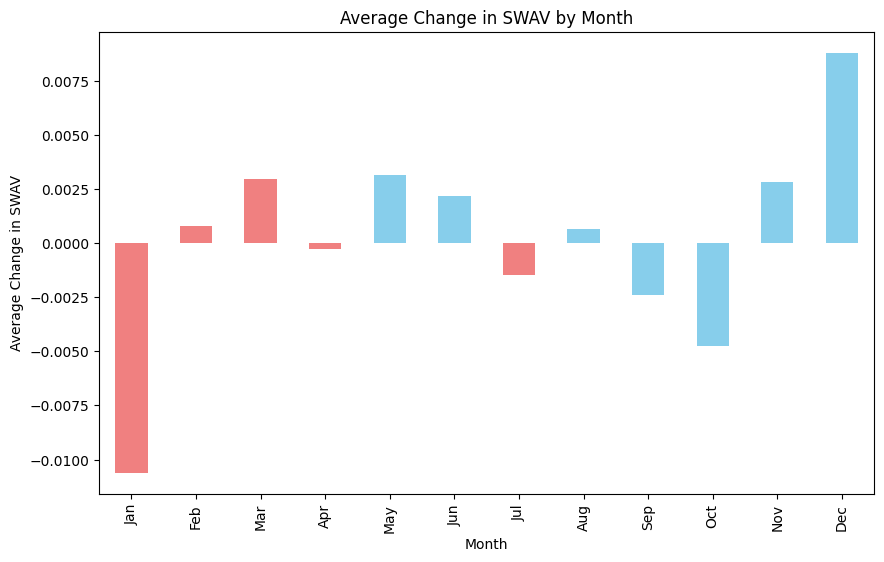

In [162]:
# Initialize an empty list to store results
results = []
model_summaries = []  # Store model summaries to print later

indices = ['FTSE100', 'FTSE250', 'FTSESmallCap']
days_list = [5]

for days in days_list:
    result_row = [days]  # Start the row with the number of days
    for index in indices:
        df = globals()[f'df_{days}_day']  # Dynamically access each DataFrame

        # Ensure 'Date' column is in datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract the month from the 'Date' column
        df['Month'] = df['Date'].dt.month

        # Step 1: Regress "Change in SWAV" on Month Dummies to obtain residuals
        month_dummies = pd.get_dummies(df['Month'], prefix='Month')
        month_dummies = month_dummies.astype(int)  # Ensure dummies are integers

        # Add constant to month dummies
        X_dummies = sm.add_constant(month_dummies)
        y_swav = df['Change in SWAV']

        # Convert to numeric and drop NaNs
        X_dummies = X_dummies.apply(pd.to_numeric, errors='coerce')
        y_swav = pd.to_numeric(y_swav, errors='coerce')

        # Drop rows with any NaN values
        X_dummies = X_dummies.dropna()
        y_swav = y_swav.loc[X_dummies.index]

        # Fit the model to get residuals
        model_dummies = sm.OLS(y_swav, X_dummies).fit()
        df['Residual_SWAV'] = model_dummies.resid

        # Step 2: Use Residual_SWAV in the main regression
        y = df[f'% {index} Change']

        # Define the independent variables, replacing 'Change in SWAV' with 'Residual_SWAV'
        X = df[['Residual_SWAV',
                'ADS_Change',
                'EPU_Change',
                f'Previous % {index} Change',
                '% MSCI Change',
                'Vix Close',
                'Rolling_Avg_Change_in_DCC']]

        # Convert all columns to numeric, coercing errors to NaN
        X = X.apply(pd.to_numeric, errors='coerce')
        y = pd.to_numeric(y, errors='coerce')

        # Drop rows with any NaN values
        X = X.dropna()
        y = y.loc[X.index]  # Ensure 'y' aligns with 'X' after dropping NaNs

        # Ensure that both X and y are aligned and are purely numeric
        if X.shape[0] > 0 and y.shape[0] > 0:  # Proceed only if there's valid data
            # Add a constant term to the model
            X = sm.add_constant(X)

            # Fit the model
            model = sm.OLS(y, X).fit()

            # Extract the coefficient and p-value for 'Residual_SWAV'
            coef = round(model.params['Residual_SWAV'], 2)
            p_value = round(model.pvalues['Residual_SWAV'], 5)

            # Store the coefficient and p-value as a tuple
            result_row.append((coef, p_value))

            # Store the model summary to print later if significant
            if p_value < 0.1:
                model_summaries.append((index, days, model.summary()))

        else:
            result_row.append((None, None))  # Store None for both if no valid data

    # Append the result row for this combination of days
    results.append(result_row)

# Define column names dynamically, ensuring "Days" is the first column
columns = ['Business Days']
for index in indices:
    columns.extend([f'Residual SWAV on {index} Change'])

# Convert the results list to a DataFrame, extracting only the coefficients
results_df = pd.DataFrame([[row[0]] + [r[0] if isinstance(r, tuple) else None for r in row[1:]] for row in results], columns=columns)

# Define a function to apply the styling based on significance
def color_rows(row, original_results):
    colors = []
    for i in range(1, len(row)):  # Skip Days, then iterate through Coefs
        # Safely access the original tuple
        item = original_results[row.name][i]
        if isinstance(item, tuple):
            coef, p_value = item
            if coef is not None and p_value < 0.1:  # Only color if p-value < 0.1 (significant)
                if coef > 0:
                    colors.append('background-color: lightgreen')
                elif coef < 0:
                    colors.append('background-color: lightpink')
                else:
                    colors.append('')
            else:
                colors.append('')  # No color for non-significant or None
        else:
            colors.append('')  # No color if item is not a tuple
    return [''] * 1 + colors  # No coloring for Days

# Apply the function to each row of the DataFrame, passing the original results
styled_df = results_df.style.apply(color_rows, axis=1, original_results=results)

# Display the styled DataFrame (in Jupyter or similar environments)
box_message = (
    "--------------------------------------------\n"
    "| Coefficients of 'Residual SWAV' by index  |\n"
    "|                                           |\n"
    "| Light green: Significant positive (10%)   |\n"
    "| Light pink: Significant negative (10%)    |\n"
    "--------------------------------------------\n"
)

# @title
# Calculate the average 'Change in SWAV' by month
monthly_avg = df_5_day.groupby('Month')['Change in SWAV'].mean()

# Plot the average 'Change in SWAV' by month
plt.figure(figsize=(10, 6))

# Assign colors, with January and December as light coral
# colors = ['lightcoral'] + ['skyblue'] * 10 + ['lightcoral']

monthly_avg.plot(kind='bar', color=colors)
plt.title('Average Change in SWAV by Month')
plt.xlabel('Month')
plt.ylabel('Average Change in SWAV')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()



# **Regress with Residual SWAV**

In [163]:
print(box_message)
display(styled_df)

# Print all the stored model summaries after displaying the styled DataFrame
for index, days, summary in model_summaries:
    print(f"\n\033[1mModel Summary for {index} at {days} days:\033[0m")
    print(summary)

--------------------------------------------
| Coefficients of 'Residual SWAV' by index  |
|                                           |
| Light green: Significant positive (10%)   |
| Light pink: Significant negative (10%)    |
--------------------------------------------



,Business Days,Residual SWAV on FTSE100 Change,Residual SWAV on FTSE250 Change,Residual SWAV on FTSESmallCap Change
0,5,-7.080000,-3.360000,0.480000



Model Summary for FTSE100 at 5 days:
                            OLS Regression Results                            
Dep. Variable:       % FTSE100 Change   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     342.1
Date:                Sat, 31 Aug 2024   Prob (F-statistic):          2.81e-319
Time:                        17:46:43   Log-Likelihood:                -3029.7
No. Observations:                1712   AIC:                             6075.
Df Residuals:                    1704   BIC:                             6119.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

# **Adding Controls: Stringency Index**

To account for pandemic-related dynamics, the COVID-19 stringency index and an interaction term between stringency and SWAV changes were added as controls.

Even with these adjustments, the previous findings remain.

This suggests that these relationships may persist even when considering the impact of pandemic-related restrictions in the UK.

In [164]:
# @title
# Initialize an empty list to store results
results = []

indices = ['FTSE100', 'FTSE250', 'FTSESmallCap']
days_list = [5]

for days in days_list:
    result_row = [days]  # Start the row with the number of days
    for index in indices:
        df = globals()[f'df_{days}_day']  # Dynamically access each DataFrame

        # Ensure 'Date' column is in datetime format
        df.loc[:, 'Date'] = pd.to_datetime(df['Date'])

        # Extract the month from the 'Date' column
        df.loc[:, 'Month'] = df['Date'].dt.month

        # Remove Festive Months
        df = df[df['festive'] == 0].copy()  # Ensure a copy is made to avoid SettingWithCopyWarning

        # Covid Stringency Interaction Term
        df.loc[:, 'Covid_Stringency*SWAV'] = df['Change in SWAV'] * df['Stringency_Change']

        # Define the dependent variable
        y = df[f'% {index} Change']

        # Define the independent variables
        X = df[['Change in SWAV',
                'ADS_Change',
                'EPU_Change',
                f'Previous % {index} Change',
                '% MSCI Change',
                'Vix Close',
                'Rolling_Avg_Change_in_DCC',
                'Stringency_Change',
                'Covid_Stringency*SWAV'
                ]]

        # Convert all columns to numeric, coercing errors to NaN
        X = X.apply(pd.to_numeric, errors='coerce')
        y = pd.to_numeric(y, errors='coerce')

        # Drop rows with any NaN values
        X = X.dropna()
        y = y.loc[X.index]  # Ensure 'y' aligns with 'X' after dropping NaNs

        # Ensure that both X and y are aligned and are purely numeric
        if X.shape[0] > 0 and y.shape[0] > 0:  # Proceed only if there's valid data
            # Add a constant term to the model
            X = sm.add_constant(X)

            # Fit the model
            model = sm.OLS(y, X).fit()

            # Extract the coefficient and p-value for 'Change in SWAV'
            coef = round(model.params['Change in SWAV'], 2)
            p_value = round(model.pvalues['Change in SWAV'], 5)

            # Store the coefficient and p-value as a tuple
            result_row.append((coef, p_value))

    # Append the result row for this combination of days
    results.append(result_row)

# Define column names dynamically, ensuring "Days" is the first column
columns = ['Business Days']
for index in indices:
    columns.extend([f'SWAV Change on {index} Change'])

# Convert the results list to a DataFrame, extracting only the coefficients
results_df = pd.DataFrame([[row[0]] + [r[0] if isinstance(r, tuple) else None for r in row[1:]] for row in results], columns=columns)

# Define a function to apply the styling based on significance
def color_rows(row, original_results):
    colors = []
    for i in range(1, len(row)):  # Skip Days, then iterate through Coefs
        # Safely access the original tuple
        item = original_results[row.name][i]
        if isinstance(item, tuple):
            coef, p_value = item
            if coef is not None and p_value < 0.1:  # Only color if p-value < 0.1 (significant)
                if coef > 0:
                    colors.append('background-color: lightgreen')
                elif coef < 0:
                    colors.append('background-color: lightpink')
                else:
                    colors.append('')
            else:
                colors.append('')  # No color for non-significant or None
        else:
            colors.append('')  # No color if item is not a tuple
    return [''] * 1 + colors  # No coloring for Days

# Apply the function to each row of the DataFrame, passing the original results
styled_df = results_df.style.apply(color_rows, axis=1, original_results=results)

# Display the styled DataFrame (in Jupyter or similar environments)
styled_df

,Business Days,SWAV Change on FTSE100 Change,SWAV Change on FTSE250 Change,SWAV Change on FTSESmallCap Change
0,5,-6.070000,0.200000,5.430000


# **Adding Controls: TED Spread and Interaction Term**

To account for liquidity risk, the TED spread and an interaction term between TED spread and SWAV changes were added. Despite these adjustments, the previous findings persist, indicating that liquidity factors alone do not fully explain these relationships.

In [165]:
# @title
# Initialize an empty list to store results
results = []

indices = ['FTSE100', 'FTSE250', 'FTSESmallCap']
days_list = [5]

for days in days_list:
    result_row = [days]  # Start the row with the number of days
    for index in indices:
        df = globals()[f'df_{days}_day_TED']  # Dynamically access each DataFrame

        # Ensure 'Date' column is in datetime format, handling errors
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

        # Drop rows where 'Date' could not be converted (NaT values)
        df = df.dropna(subset=['Date'])

        # Extract the month from the 'Date' column
        df['Month'] = df['Date'].dt.month

        # Remove Festive Months
        df = df[df['festive'] == 0].copy()  # Copy

        # Covid Stringency Interaction Term
        df.loc[:, 'Stringency_Change*SWAV'] = df['Change in SWAV'] * df['Stringency_Change']
        df.loc[:, 'TED_Change*SWAV'] = df['Change in SWAV'] * df['TED_Change']

        # Define the dependent variable
        y = df[f'% {index} Change']

        # Define the independent variables
        X = df[['Change in SWAV',
                'ADS_Change',
                'EPU_Change',
                f'Previous % {index} Change',
                '% MSCI Change',
                'Vix Close',
                'Rolling_Avg_Change_in_DCC',
                'Stringency_Change',
                'Stringency_Change*SWAV',
                'TED_Change',
                'TED_Change*SWAV'
                ]]

        # Convert all columns to numeric, coercing errors to NaN
        X = X.apply(pd.to_numeric, errors='coerce')
        y = pd.to_numeric(y, errors='coerce')

        # Drop rows with any NaN values
        X = X.dropna()
        y = y.loc[X.index]  # Ensure 'y' aligns with 'X' after dropping NaNs

        # Ensure that both X and y are aligned and are purely numeric
        if X.shape[0] > 0 and y.shape[0] > 0:  # Proceed only if there's valid data
            # Add a constant term to the model
            X = sm.add_constant(X)

            # Fit the model
            model = sm.OLS(y, X).fit()

            # Extract the coefficient and p-value for 'Change in SWAV'
            coef = round(model.params['Change in SWAV'], 2)
            p_value = round(model.pvalues['Change in SWAV'], 5)

            # Store the coefficient and p-value as a tuple
            result_row.append((coef, p_value))

    # Append the result row for this combination of days
    results.append(result_row)

# Define column names dynamically, ensuring "Days" is the first column
columns = ['Business Days']
for index in indices:
    columns.extend([f'SWAV Change on {index} Change'])

# Convert the results list to a DataFrame, extracting only the coefficients
results_df = pd.DataFrame([[row[0]] + [r[0] if isinstance(r, tuple) else None for r in row[1:]] for row in results], columns=columns)

# Define a function to apply the styling based on significance
def color_rows(row, original_results):
    colors = []
    for i in range(1, len(row)):  # Skip Days, then iterate through Coefs
        # Safely access the original tuple
        item = original_results[row.name][i]
        if isinstance(item, tuple):
            coef, p_value = item
            if coef is not None and p_value < 0.1:  # Only color if p-value < 0.1 (significant)
                if coef > 0:
                    colors.append('background-color: lightgreen')
                elif coef < 0:
                    colors.append('background-color: lightpink')
                else:
                    colors.append('')
            else:
                colors.append('')  # No color for non-significant or None
        else:
            colors.append('')  # No color if item is not a tuple
    return [''] * 1 + colors  # No coloring for Days

# Apply the function to each row of the DataFrame, passing the original results
styled_df = results_df.style.apply(color_rows, axis=1, original_results=results)

# Display the styled DataFrame (in Jupyter or similar environments)
styled_df

,Business Days,SWAV Change on FTSE100 Change,SWAV Change on FTSE250 Change,SWAV Change on FTSESmallCap Change
0,5,-4.960000,0.210000,5.070000


# **Multicollinearity Check**

A Variance Inflation Factor (VIF) analysis confirms that multicollinearity is not an issue in the regression models, supporting the reliability of the results.




In [166]:
# @title
# Calculate interaction terms
df_5_day_TED.loc[:, 'Stringency_Change*SWAV'] = df_5_day_TED['Change in SWAV'] * df_5_day_TED['Stringency_Change']
df_5_day_TED.loc[:, 'TED_Change*SWAV'] = df_5_day_TED['Change in SWAV'] * df_5_day_TED['TED_Change']

# Define the independent variables
X = df_5_day_TED[['Change in SWAV',
                  'ADS_Change',
                  'EPU_Change',
                  f'Previous % {index} Change',
                  '% MSCI Change',
                  'Vix Close',
                  'Rolling_Avg_Change_in_DCC',
                  'Stringency_Change',
                  'Stringency_Change*SWAV',
                  'TED_Change',
                  'TED_Change*SWAV']]

# Add a constant to the independent variables matrix (for intercept)
X = sm.add_constant(X)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Style the VIF DataFrame
styled_vif = vif_data.style.set_caption("Variance Inflation Factors (VIF)")
styled_vif = styled_vif.set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('padding', '8px')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]},
    {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]}
])

# Display the styled VIF DataFrame
display(styled_vif)

,feature,VIF
0,const,6.806887
1,Change in SWAV,1.057909
2,ADS_Change,1.695449
3,EPU_Change,1.036970
4,Previous % FTSESmallCap Change,1.666840
5,% MSCI Change,1.198593
6,Vix Close,1.291401
7,Rolling_Avg_Change_in_DCC,1.015279
8,Stringency_Change,1.843701
9,Stringency_Change*SWAV,1.306903


# **Assessing Robustness Using Different Timeframes**
The analysis shows varying robustness in the relationship between SWAV changes and UK market returns:

*   FTSE 100: Significant negative relationships in the 3-day and 5-day windows
suggest a short-to-medium term impact, with no immediate effect seen in the 1-day or longer-term 10-day windows.

*   FTSE 250: A significant positive relationship appears only in the 10-day window, indicating a gradual influence of sentiment on this index.

*   FTSE Small Cap: Consistent positive relationships across all windows highlight a strong, robust response to sentiment changes in smaller, riskier stocks.

These results suggest that sentiment impacts market returns differently depending on the index and timeframe, with FTSE Small Cap showing the most consistent response.

In [167]:
# @title
# Initialize an empty list to store results
results = []

indices = ['FTSE100', 'FTSE250', 'FTSESmallCap']
days_list = [1,3,5,10]

for days in days_list:
    result_row = [days]  # Start the row with the number of days
    for index in indices:
        df = globals()[f'df_{days}_day_TED']  # Dynamically access each DataFrame

        # Ensure 'Date' column is in datetime format, handling errors
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

        # Drop rows where 'Date' could not be converted (NaT values)
        df = df.dropna(subset=['Date'])

        # Extract the month from the 'Date' column
        df['Month'] = df['Date'].dt.month

        # Remove Festive Months
        df = df[df['festive'] == 0].copy()  # Copy the filtered DataFrame to avoid SettingWithCopyWarning

        # Covid Stringency Interaction Term
        df.loc[:, 'Stringency_Change*SWAV'] = df['Change in SWAV'] * df['Stringency_Change']
        df.loc[:, 'TED_Change*SWAV'] = df['Change in SWAV'] * df['TED_Change']

        # Define the dependent variable
        y = df[f'% {index} Change']

        # Define the independent variables
        X = df[['Change in SWAV',
                'ADS_Change',
                'EPU_Change',
                f'Previous % {index} Change',
                '% MSCI Change',
                'Vix Close',
                'Rolling_Avg_Change_in_DCC',
                'Stringency_Change',
                'Stringency_Change*SWAV',
                'TED_Change',
                'TED_Change*SWAV'
                ]]

        # Convert all columns to numeric, coercing errors to NaN
        X = X.apply(pd.to_numeric, errors='coerce')
        y = pd.to_numeric(y, errors='coerce')

        # Drop rows with any NaN values
        X = X.dropna()
        y = y.loc[X.index]  # Ensure 'y' aligns with 'X' after dropping NaNs

        # Ensure that both X and y are aligned and are purely numeric
        if X.shape[0] > 0 and y.shape[0] > 0:  # Proceed only if there's valid data
            # Add a constant term to the model
            X = sm.add_constant(X)

            # Fit the model
            model = sm.OLS(y, X).fit()

            # Extract the coefficient and p-value for 'Change in SWAV'
            coef = round(model.params['Change in SWAV'], 2)
            p_value = round(model.pvalues['Change in SWAV'], 5)

            # Store the coefficient and p-value as a tuple
            result_row.append((coef, p_value))

    # Append the result row for this combination of days
    results.append(result_row)

# Define column names dynamically, ensuring "Days" is the first column
columns = ['Business Days']
for index in indices:
    columns.extend([f'SWAV Change on {index} Change'])

# Convert the results list to a DataFrame, extracting only the coefficients
results_df = pd.DataFrame([[row[0]] + [r[0] if isinstance(r, tuple) else None for r in row[1:]] for row in results], columns=columns)

# Define a function to apply the styling based on significance
def color_rows(row, original_results):
    colors = []
    for i in range(1, len(row)):  # Skip Days, then iterate through Coefs
        # Safely access the original tuple
        item = original_results[row.name][i]
        if isinstance(item, tuple):
            coef, p_value = item
            if coef is not None and p_value < 0.1:  # Only color if p-value < 0.1 (significant)
                if coef > 0:
                    colors.append('background-color: lightgreen')
                elif coef < 0:
                    colors.append('background-color: lightpink')
                else:
                    colors.append('')
            else:
                colors.append('')  # No color for non-significant or None
        else:
            colors.append('')  # No color if item is not a tuple
    return [''] * 1 + colors  # No coloring for Days

# Apply the function to each row of the DataFrame, passing the original results
styled_df = results_df.style.apply(color_rows, axis=1, original_results=results)

# Display the styled DataFrame (in Jupyter or similar environments)
styled_df

,Business Days,SWAV Change on FTSE100 Change,SWAV Change on FTSE250 Change,SWAV Change on FTSESmallCap Change
0,1,-2.280000,-1.010000,-1.070000
1,3,-4.520000,2.290000,4.310000
2,5,-4.960000,0.210000,5.070000
3,10,-0.660000,5.140000,9.300000


# **Lagged Analysis: Delayed Market Reactions**

A lagged regression shows a significant positive relationship for the FTSE 100 in the 5-day and 10-day windows. This suggests that initial negative market reactions to sentiment changes might shift over time, possibly indicating a delayed correction consistent with risk-off behavior.

No significant effects were found for other indices, hinting that this pattern may be specific to the FTSE 100.

In [168]:
# @title
# Initialize an empty list to store results
results = []

indices = ['FTSE100', 'FTSE250', 'FTSESmallCap']
days_list = [1,3,5,10]

for days in days_list:
    result_row = [days]  # Start the row with the number of days
    for index in indices:
        df = globals()[f'df_{days}_day_TED']  # Dynamically access each DataFrame

        # Ensure 'Date' column is in datetime format
        df.loc[:, 'Date'] = pd.to_datetime(df['Date'])

        # Extract the month from the 'Date' column
        df.loc[:, 'Month'] = df['Date'].dt.month

        # Remove Festive Months
        df = df[df['festive'] == 0].copy()  # Copy the filtered DataFrame to avoid SettingWithCopyWarning

        # Covid Stringency Interaction Term
        df.loc[:, 'Stringency_Change*SWAV'] = df['Change in SWAV'] * df['Stringency_Change']
        df.loc[:, 'TED_Change*SWAV'] = df['Change in SWAV'] * df['TED_Change']

        # Define the dependent variable
        y = df[f'Next % {index} Change']

        # Define the independent variables
        X = df[['Change in SWAV',
                'ADS_Change',
                'EPU_Change',
                f'% {index} Change',
                'Next % MSCI Change',
                'Vix Close',
                'Rolling_Avg_Change_in_DCC',
                'Stringency_Change',
                'Stringency_Change*SWAV',
                'TED_Change',
                'TED_Change*SWAV'
                ]]

        # Convert all columns to numeric, coercing errors to NaN
        X = X.apply(pd.to_numeric, errors='coerce')
        y = pd.to_numeric(y, errors='coerce')

        # Drop rows with any NaN values
        X = X.dropna()
        y = y.loc[X.index]  # Ensure 'y' aligns with 'X' after dropping NaNs

        # Ensure that both X and y are aligned and are purely numeric
        if X.shape[0] > 0 and y.shape[0] > 0:  # Proceed only if there's valid data
            # Add a constant term to the model
            X = sm.add_constant(X)

            # Fit the model
            model = sm.OLS(y, X).fit()

            # Extract the coefficient and p-value for 'Change in SWAV'
            coef = round(model.params['Change in SWAV'], 2)
            p_value = round(model.pvalues['Change in SWAV'], 5)

            # Store the coefficient and p-value as a tuple
            result_row.append((coef, p_value))

    # Append the result row for this combination of days
    results.append(result_row)

# Define column names dynamically, ensuring "Days" is the first column
columns = ['Business Days']
for index in indices:
    columns.extend([f'SWAV Change on Next Period {index} Change'])

# Convert the results list to a DataFrame, extracting only the coefficients
results_df = pd.DataFrame([[row[0]] + [r[0] if isinstance(r, tuple) else None for r in row[1:]] for row in results], columns=columns)

# Define a function to apply the styling based on significance
def color_rows(row, original_results):
    colors = []
    for i in range(1, len(row)):  # Skip Days, then iterate through Coefs
        # Safely access the original tuple
        item = original_results[row.name][i]
        if isinstance(item, tuple):
            coef, p_value = item
            if coef is not None and p_value < 0.1:  # Only color if p-value < 0.1 (significant)
                if coef > 0:
                    colors.append('background-color: lightgreen')
                elif coef < 0:
                    colors.append('background-color: lightpink')
                else:
                    colors.append('')
            else:
                colors.append('')  # No color for non-significant or None
        else:
            colors.append('')  # No color if item is not a tuple
    return [''] * 1 + colors  # No coloring for Days

# Apply the function to each row of the DataFrame, passing the original results
styled_df = results_df.style.apply(color_rows, axis=1, original_results=results)

# Display the styled DataFrame (in Jupyter or similar environments)
styled_df

,Business Days,SWAV Change on Next Period FTSE100 Change,SWAV Change on Next Period FTSE250 Change,SWAV Change on Next Period FTSESmallCap Change
0,1,-2.000000,0.730000,2.570000
1,3,2.960000,3.590000,2.870000
2,5,6.240000,4.780000,2.550000
3,10,14.640000,-1.480000,0.280000


# **Conclusion: Sentiment, Risk, and Market Dynamics**

The study finds a negative relationship between SWAV changes and FTSE 100 returns, suggesting the FTSE 100 might act as a safe asset in the UK, possibly reflecting risk-off behavior.
The positive relationship with FTSE Small Cap returns could support this, but further research is needed to fully understand these dynamics.